In [119]:
%pylab qt5
%precision 5
set_printoptions(precision=5)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)
import scipy
import scipy.optimize
import scipy.odr
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['disp', 'sqrt', 'e', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'%.5f'

In [2]:
from uncertainties import ufloat
import uncertainties as uc

In [3]:
from IPython.core.magic import register_line_magic
@register_line_magic
def disp(var):
    val = globals()[var]
    if isinstance(val, uc.core.Variable) or isinstance(val, uc.core.AffineScalarFunc):
        print(f'{var} = {val}')
    else:
        err = globals()[var+'_err']
        print(f'{var} = {val} +- {err}')

In [134]:
def sqrt(*args, **kwargs):
    if len(args) == 1 and len(kwargs) == 0 and isinstance(args[0], uc.core.Variable) \
       or isinstance(args[0], uc.core.AffineScalarFunc):
        return args[0]**(1/2)
    else:
        return np.sqrt(*args, **kwargs) 

In [5]:
def conv(s):
    if s==b'':
        return NaN
    else:
        return float(s)

def filternan(arr):
    return arr[~isnan(arr)]

verwenden cm als Einheiten

## Autokollimation für 1 Linse

In [6]:
# lade Daten
autokollB = loadtxt('./autokollB.csv', delimiter=',', skiprows=1,
                   converters=dict(zip([0], [lambda s: NaN if s==b'' else float(s)]*2)))
autokollG = loadtxt('./autokollG.csv', delimiter=',', skiprows=1,
                   converters=dict(zip([0], [lambda s: NaN if s==b'' else float(s)]*2)))

In [7]:
gK = 29.6
gK_err = 0.2

In [8]:
fBK = mean(autokollB) - gK
fBK_err = std(autokollB, ddof=1) + gK_err
fGK = mean(autokollG) - gK
fGK_err = std(autokollG, ddof=1) + gK_err
%disp fBK
%disp fGK
fBK_err/fBK

fBK = 9.63636363636364 +- 0.2595437196138638
fGK = 7.050000000000004 +- 0.29999999999999905


0.026933782224080195

## Bessel für 1 Linse

In [9]:
g = 30
g_err = 0.2

In [10]:
# lade Daten
A1_B, A2_B = transpose(loadtxt('./besselB.csv', delimiter=',', skiprows=1,
                               converters=dict(zip([0], [lambda s: NaN if s==b'' else float(s)]))))
A1_G, A2_G = transpose(loadtxt('./besselG.csv', delimiter=',', skiprows=1,
                               converters=dict(zip([0], [lambda s: NaN if s==b'' else float(s)]))))

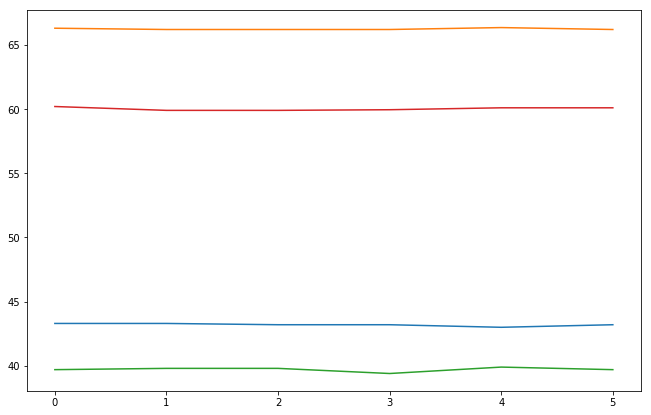

In [11]:
plt.plot(A1_B)
plt.plot(A2_B)
plt.plot(A1_G)
plt.plot(A2_G)

In [12]:
# für B
e = 80 - g - .5 * .185
e_err = sqrt(g_err**2 + .1**2)

d = mean(A2_B - A1_B)
d_err = sqrt(std(A1_B, ddof=1)**2 + std(A2_B, ddof=1)**2)

fBS = .25 * (e - d**2/e)
fBS_err = .5/e * d * d_err + (.25 + d**2/e**2) * e_err
%disp fBS

fBS = 9.817362888705215 +- 0.13314211396614556


In [13]:
(fBS_err**-2 * fBS + fBK_err**-2 * fBK)/(fBS_err**-2 + fBK_err**-2)

9.779655161757892

In [14]:
# für G
e = 70 - g- .5 * .185
e_err = sqrt(g_err**2 + .1**2)

d = mean(A2_G - A1_G)
d_err = sqrt(std(A1_G, ddof=1)**2 + std(A2_G, ddof=1)**2)

fGS = .25 * (e - d**2/e)
fGS_err = .5/e * d * d_err + (.25 + d**2/e**2) * e_err
%disp fGS

fGS = 7.393222786896086 +- 0.16803255652727045


In [15]:
%disp d

d = 20.308333333333334 +- 0.21311186420907413


## Autokollimation + Bessel für ein Linsensystem

In [16]:
g = 30

In [17]:
syst = ufloat(0, 0.1)

In [18]:
# lade Daten
KK, LL = transpose(loadtxt('./autokollBE.csv', delimiter=',', skiprows=1))
A1_BE, A2_BE = transpose(loadtxt('./besselBE.csv', delimiter=',', skiprows=1,
                                 converters=dict(zip([0, 1], [lambda s: NaN if s==b'' else float(s)]*2))))

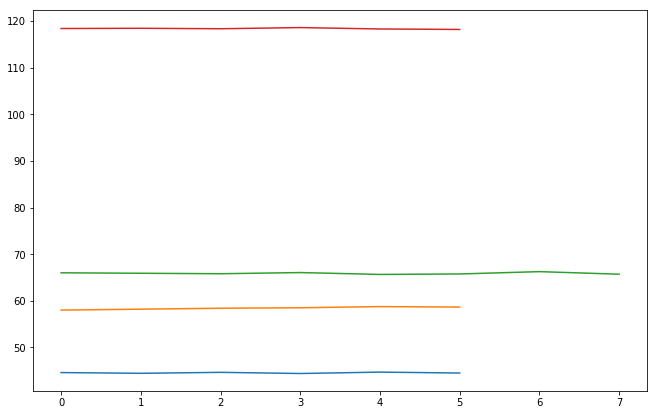

In [19]:
plt.plot(KK)
plt.plot(LL)
plt.plot(A1_BE)
plt.plot(A2_BE)

In [20]:
g_unc = ufloat(g, g_err)
k = ufloat(mean(KK), std(KK, ddof=1)) - g_unc
l = ufloat(mean(LL), std(LL, ddof=1)) - g_unc
%disp k
%disp l

k = 14.55+/-0.23
l = 28.42+/-0.34


In [21]:
eBE = ufloat(140, 0.1) - g_unc
%disp eBE

eBE = 110.00+/-0.22


In [22]:
A2_BE = A2_BE[~isnan(A2_BE)]
dBE = ufloat(mean(A2_BE) - mean(A1_BE), sqrt(std(A1_BE, ddof=1)**2 + std(A2_BE, ddof=1)**2))
%disp dBE

dBE = 52.50+/-0.24


In [135]:
fC = .5 * sqrt((eBE - k - l)**2 - dBE**2)
# f_err = .25 / f * sqrt(dBE**2 * dBE_err**2 + (eBE - k - l)**2 * (eBE_err**2 + k_err**2 + l_err**2))

h = k + l - 2*fC
# h_err = sqrt(k_err**2*(1 + (1.*(eBE - k - l))/sqrt(-dBE**2 + (eBE - k - l)**2))**
#           2 + (1.*dBE**2*dBE_err**2)/(-dBE**2 + (eBE - k - l)**2) + 
#         (1.*eBE_err**2*(eBE - k - l)**2)/(-dBE**2 + (eBE - k - l)**2) + 
#         (1 + (1.*(eBE - k - l))/sqrt(-dBE**2 + (eBE - k - l)**2))**2*l_err**2)
    
%disp fC
%disp h

fC = 20.84+/-0.34
h = 1.3+/-1.1


## Abbe für Linsensystem

In [24]:
gA = 15

In [25]:
L, G1, G2, s1_4, s2_4 = transpose(loadtxt('./abbeBE.csv', delimiter=',', skiprows=1,
                                  converters=dict(zip(range(5), [conv]*5))))
gg = -(hstack([G1, G2[::-1]]) - gA)
gg_ = hstack([L, L[::-1]]) - gA + gg
gg = filternan(gg)
gg_ = filternan(gg_)

β = -hstack([s1_4, s2_4[::-1]])/4 / .5
β = filternan(β)

In [121]:
# plt.plot(L)
# plt.plot(G1)
# plt.plot(G2)
# plt.plot(s1_4)
# plt.plot(s2_4)

In [27]:
len(gg), len(gg_)

(21, 21)

In [43]:
β_err = 0.1 / 4 / .5
β_err

0.05000

In [51]:
data = scipy.odr.Data(1 - 1/β, gg, wd=1/β**2 * β_err)
odr = scipy.odr.ODR(data, scipy.odr.unilinear, [20, 1])
result = odr.run()
result.pprint()

Beta: [-20.07489  -8.84203]
Beta Std Error: [0.19761 0.69458]
Beta Covariance: [[  306.14501 -1053.19799]
 [-1053.19799  3782.17763]]
Residual Variance: 0.00012755471255321076
Inverse Condition #: 0.0028846438265418906
Reason(s) for Halting:
  Sum of squares convergence


In [62]:
data_ = scipy.odr.Data(1 - β, gg_, wd=β_err)
odr_ = scipy.odr.ODR(data_, scipy.odr.unilinear, [20, 1])
result_ = odr_.run()
result_.pprint()

Beta: [19.73454 -5.18594]
Beta Std Error: [0.08283 0.24726]
Beta Covariance: [[ 228.16656 -615.80524]
 [-615.80524 2032.96913]]
Residual Variance: 3.007204805912685e-05
Inverse Condition #: 0.007097840685252199
Reason(s) for Halting:
  Sum of squares convergence


<ErrorbarContainer object of 3 artists>

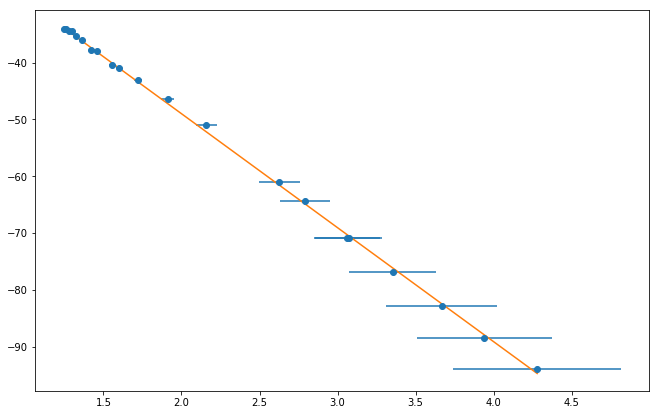

In [77]:
plt.errorbar(1 - 1/β, gg, fmt='o', xerr=1/β**2 * β_err)
x = linspace(min(1 - 1/β), max(1 - 1/β))
plt.plot(x, result.beta[0]*x + result.beta[1])

savetxt('diag_g.csv', transpose([1 - 1/β, 1/β**2 * β_err, gg]), delimiter=',', comments='', header='x, x_err, g')

<ErrorbarContainer object of 3 artists>

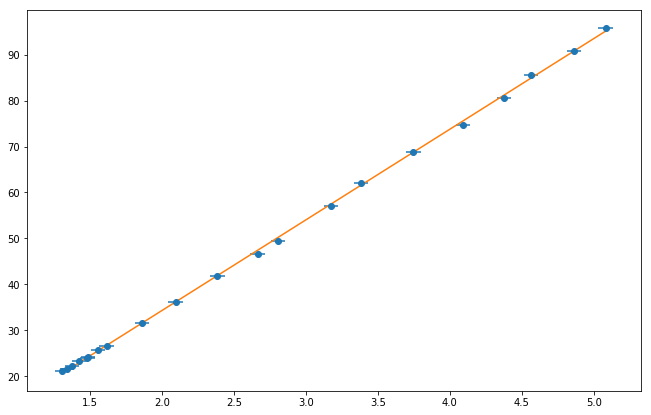

In [120]:
plt.errorbar(1 - β, gg_, xerr=β_err, fmt='o')
x = linspace(min(1 - β), max(1 - β))
plt.plot(x, result_.beta[0]*x + result_.beta[1])

savetxt('diag_g_.csv', transpose([1 - β, β_err*ones_like(β), gg_]), delimiter=',', comments='', header='x, x_err, g_')

In [71]:
fA = ufloat(.5*(-result.beta[0] + result_.beta[0]), .5*(result.sd_beta[0] + result_.sd_beta[1]))
%disp fA

fA = 19.90+/-0.22


In [72]:
20 * (5 - fBS)/(20 - fBS)

-9.461916075476559

In [73]:
Δ = 5 - fBS - (-10)
5**2 / Δ

4.823799055024754

In [84]:
pos_err = ufloat(0, .2)
h1 = ufloat(result.beta[1], result.sd_beta[1]) + pos_err
h2 = ufloat(result_.beta[1], result_.sd_beta[1]) + pos_err
h1
%disp h1
%disp h2

-8.842030329646077+/-0.722796361688976

h1 = -8.8+/-0.7
h2 = -5.19+/-0.32


In [83]:
h2 - h1

3.6560948646666027+/-0.7372720839357021

In [87]:
ufloat(result.beta[1], result.sd_beta[1]), ufloat(result_.beta[1], result_.sd_beta[1])

(-8.842030329646077+/-0.6945751078687034,
 -5.185935464979474+/-0.24725603183759146)

## Aufgabe 7

In [90]:
%disp fBK
%disp fBS

fBK = 9.63636363636364 +- 0.2595437196138638
fBS = 9.817362888705215 +- 0.13314211396614556


In [93]:
fB = ufloat((fBK_err**-2 * fBK + fBS_err**-2 * fBS)/(fBK_err**-2 + fBS_err**-2), 1/sqrt(fBK_err**-2 + fBS_err**-2))
%disp fB

fB = 9.78+/-0.12


In [128]:
f1 = ufloat(19.735, 0.083)
f2 = ufloat(20.07, 0.198)
f = ufloat(.5*(-result.beta[0] + result_.beta[0]), .5*(result.sd_beta[0] + result_.sd_beta[0]))
%disp f

f = 19.90+/-0.14


In [131]:
t = ufloat(5, 0.1)

In [132]:
fE = (-f * fB + f * t)/(f - fB)
%disp fE

fE = -9.4+/-0.4
